# Accounting for Spatial Autocorrelation in Regression Models

Tobler's First Law of Geography says *"Everything is related to everything else.  But near things are more related than distant things."*  

An important assumption when performing traditional regressions is that observations are independent.  The fact that observation A is high does not affect the probability that observation B is also high.  

Tobler's First Law means that for spatial datasets, that assumption basically never holds.  If observation A is close to observation B, they will likely have similar values (i.e. they are **spatially autocorrelated**).  If our observations are no longer independent, we can't rely on the results of an ordinary regression.

This notebook provides you with some tools to account for spatially autocorrelation, specifically a **spatial lag model** and a **spatial error model**.

## Step 1: Load the necessary libraries

When you run the cell below, you may get a warning regarding the specific version of R the libraries were built under.  You can ignore this warning.

In [17]:
library(spdep)
library(spatialreg)
library(GISTools)
library(rgdal)
library(RColorBrewer)

## Step 2: Load the data

Spatial datasets that you want to use in R are most conveniently stored in a data format called a shapefile (which is actually a collection of several files).

To be able to use them in R, however, you will need to load them into a spatial data frame.  The code below will load the file and print out a summary of a toy dataset designed to illustrate the problems of spatial autocorrelation.

The important data fields in this data set are CRIME, which is a measure of the crime rate in each region, and MINPOP, which is a measure of the population of color in each region.

In [21]:
sdf <-readOGR("examples.shp")
summary(sdf)

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\orms0027\Documents\day_of_data\examples.shp", layer: "examples"
with 84 features
It has 4 fields


Object of class SpatialPolygonsDataFrame
Coordinates:
       min      max
x 175837.0 215596.1
y 579810.7 607728.8
Is projected: TRUE 
proj4string :
[+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0
+datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0]
Data attributes:
       Id           GRID_ID       CRIME            MINPOP      
 Min.   : 0.00   A-1    : 1   Min.   :  1.00   Min.   :  1.00  
 1st Qu.: 0.00   A-2    : 1   1st Qu.:  1.00   1st Qu.:  1.00  
 Median : 6.50   A-3    : 1   Median :  1.00   Median :  1.00  
 Mean   :14.24   A-4    : 1   Mean   : 12.01   Mean   : 12.01  
 3rd Qu.:29.25   A-5    : 1   3rd Qu.: 13.50   3rd Qu.: 13.50  
 Max.   :48.00   A-6    : 1   Max.   :101.00   Max.   :101.00  
                 (Other):78                                    

## Step 3: Visualize the Data

tmap is a good library to visualize spatial data in R, but sometimes it doesn't work.  Below is a function that will create a choropleth map from a spatial data frame using the GISTools library instead.  

You can read more about creating these types of maps in GISTools at https://www.rdocumentation.org/packages/GISTools/versions/0.7-4/topics/choropleth

In [75]:
choropleth_map <- function(var,title,classes,cutter=sdCuts, ramp="RdPu") {
    variable <- as.numeric(var)
    variable.shade <- auto.shading(variable,cutter=cutter,n=classes,cols=brewer.pal(classes,ramp))
    choropleth(sdf,variable,shading=variable.shade)
    title(title, cex.main=2)  
}

If we want to visualize the variables, we need to pass correct parameters to the function we defined above.  Let's start with the MINPOP variable

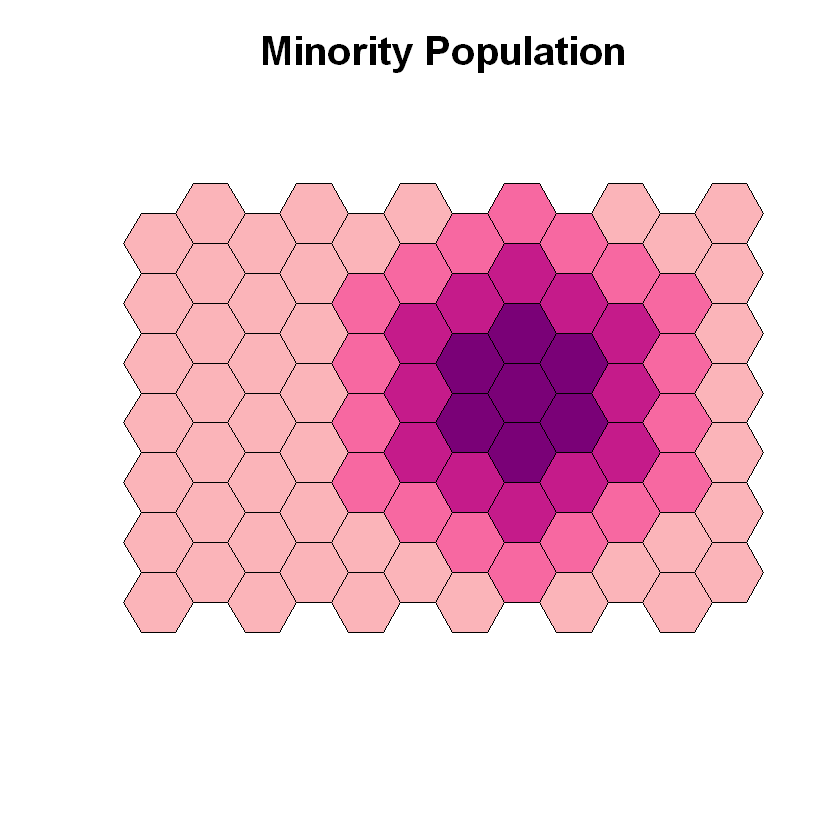

In [76]:
var = sdf$MINPOP # which variable will be mapped
title = "Minority Population" # the title to print at the top of the figure
classes = 5 # the number of groups to break the data into

choropleth_map (var,title, classes)

Next we can map the CRIME variable.  Try to create this code on your ownin the cell below, using the example in the cell above.  If you have trouble, check here for an answer: 

## Step 4: Create a non-spatial regression model

Visually, we can see that the two variables have quite a bit of overlap, which makes us think they might be correlated.  The code below will create an ordinary least squares (OLS) regression model with MINPOP as the explanatory variable and CRIME as the response variable.


Call:
lm(formula = CRIME ~ MINPOP, data = sdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.303  -6.026  -6.026   6.474  82.655 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.57329    2.07338   3.170  0.00214 ** 
MINPOP       0.45277    0.09846   4.598 1.53e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 15.61 on 82 degrees of freedom
Multiple R-squared:  0.205,	Adjusted R-squared:  0.1953 
F-statistic: 21.14 on 1 and 82 DF,  p-value: 1.53e-05


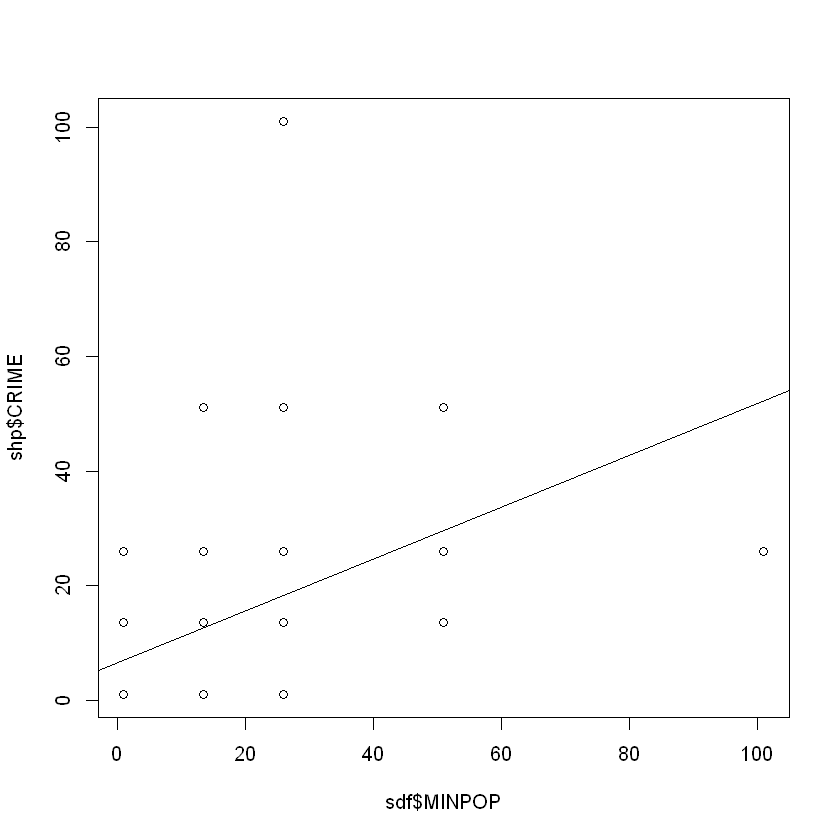

In [81]:
# create the regression model
ols <- lm(CRIME ~ MINPOP, data = sdf)

#print the summary
summary(ols)

#plot the relationship
plot(sdf$MINPOP, shp$CRIME)
abline(ols)

Based on these results, how would you interpret the relationship between these two variables?

## Step 5: Think Spatially

Just looking at the results above, you might rush to publish your analysis without thinking about the effects of spatial autocorrelation.

But since you were smart enough to attend this session, you know better than that.  

What if we mapped the residuals from the OLS model?  If the model was appropriate, then you wouldn't be able to use a region's location to predict the value of the residual (i.e. the residuals would be spatially random).

The code below will use our mapping function to map the residuals

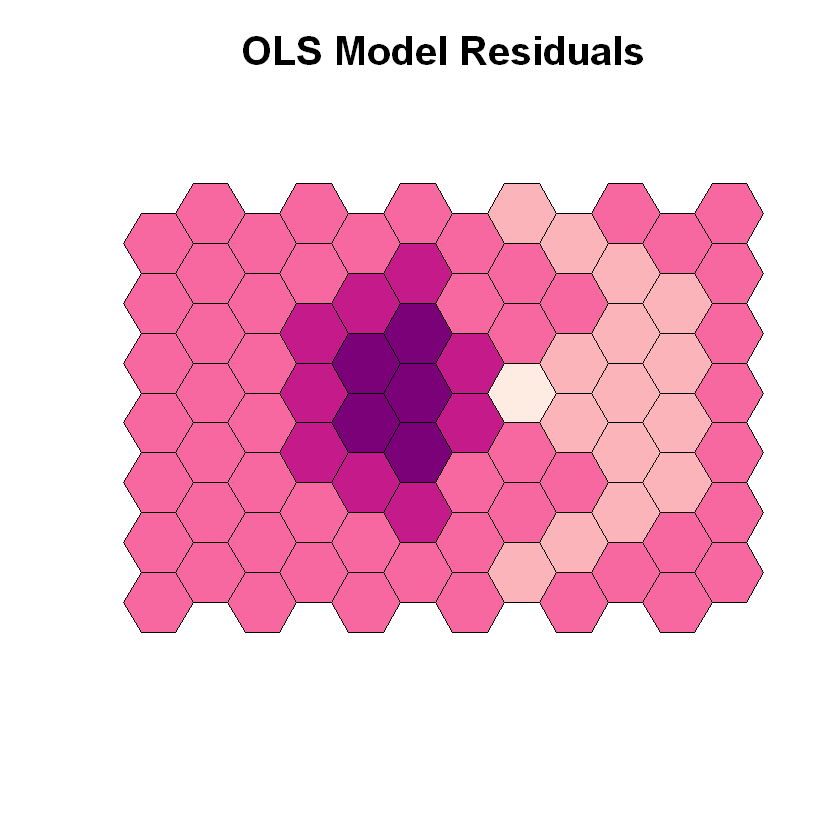

In [86]:
var = resid(ols) # which variable will be mapped
title = "OLS Model Residuals" # the title to print at the top of the figure
classes = 5 # the number of groups to break the data into

choropleth_map (var,title, classes)

In [ ]:
Does that look spatially random to you?

Moran's I is a measure of the degree of spatial autocorrelation in a dataset.  A value of 0 indicates no autocorrelation.  A positive value indicates that Tobler's law holds true: close things are more similar than distant things.  A negative value indicates the opposite: close things are more dissimilar than distant things (this is pretty rare in real life).

To calculate Moran's I, the first thing we need to do is figure out what it means for things to be "close".  We'll use the definition that two regions are "close" if they share an edge.

The code below will convert the region polygons into a contiguity graph where each region is a node and each edge connects a region to the other regions it shares an edge with.

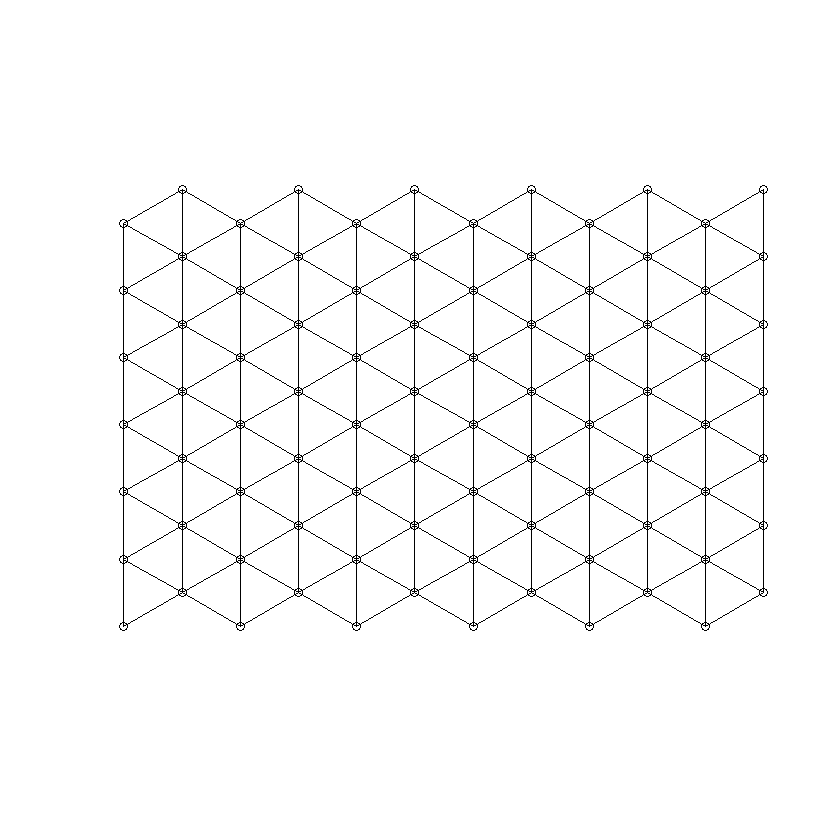

In [87]:
# create a contiguity graph
sdf.nb <- poly2nb(sdf)

# visualize the contiguity graph
plot(sdf.nb, coordinates(sdf))

We can use that contiguity graph to create what's called a row-standardized spatial weights matrix.  This matrix is needed to calculate Moran's I.

We're not going to go into all the math behind what this matrix is, but you can read more about it here: https://geodacenter.github.io/workbook/4a_contig_weights/lab4a.html

In [89]:
W <- nb2listw(sdf.nb)

Once we have the weights matrix, we can measure the autocorrelation in the residuals.  Given the map we saw above, we should expect this number to be positive and closer to 1 than 0.

The code below will calculate Moran's I

In [90]:
# add the residuals as a field to the spatial data frame
sdf$ols.res <- resid(ols) 

# calculate Moran's I
moran.test(sdf$ols.res,W)


	Moran I test under randomisation

data:  sdf$ols.res  
weights: W    

Moran I statistic standard deviate = 10.799, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.678932730      -0.012048193       0.004094336 


In [14]:
# Use Lagrange multiplier test to determine if spatial lag or spatial error
# provides the better model fit
LM <- lm.LMtests(ols, W, test="all")
LM


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = CRIME ~ MINPOP, data = shp)
weights: W

LMerr = 94.183, df = 1, p-value < 2.2e-16


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = CRIME ~ MINPOP, data = shp)
weights: W

LMlag = 99.479, df = 1, p-value < 2.2e-16


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = CRIME ~ MINPOP, data = shp)
weights: W

RLMerr = 0.061337, df = 1, p-value = 0.8044


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = CRIME ~ MINPOP, data = shp)
weights: W

RLMlag = 5.3573, df = 1, p-value = 0.02064


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = CRIME ~ MINPOP, data = shp)
weights: W

SARMA = 99.541, df = 2, p-value < 2.2e-16


In [15]:
# create the spatial lag model
lag <- lagsarlm(CRIME ~ MINPOP, data = shp, W)
summary(lag)

Warning message:
"Function lagsarlm moved to the spatialreg package"



Call:spatialreg::lagsarlm(formula = formula, data = data, listw = listw, 
    na.action = na.action, Durbin = Durbin, type = type, method = method, 
    quiet = quiet, zero.policy = zero.policy, interval = interval, 
    tol.solve = tol.solve, trs = trs, control = control)

Residuals:
     Min       1Q   Median       3Q      Max 
-9.34832 -2.91608  0.49348  0.64815 51.18850 

Type: lag 
Coefficients: (asymptotic standard errors) 
             Estimate Std. Error z value Pr(>|z|)
(Intercept) -0.515178   0.874799 -0.5889  0.55592
MINPOP       0.071187   0.041967  1.6963  0.08984

Rho: 0.95051, LR test value: 115.53, p-value: < 2.22e-16
Asymptotic standard error: 0.025217
    z-value: 37.693, p-value: < 2.22e-16
Wald statistic: 1420.8, p-value: < 2.22e-16

Log likelihood: -291.229 for lag model
ML residual variance (sigma squared): 42.509, (sigma: 6.5199)
Number of observations: 84 
Number of parameters estimated: 4 
AIC: 590.46, (AIC for lm: 703.98)
LM test for residual autocorrelation


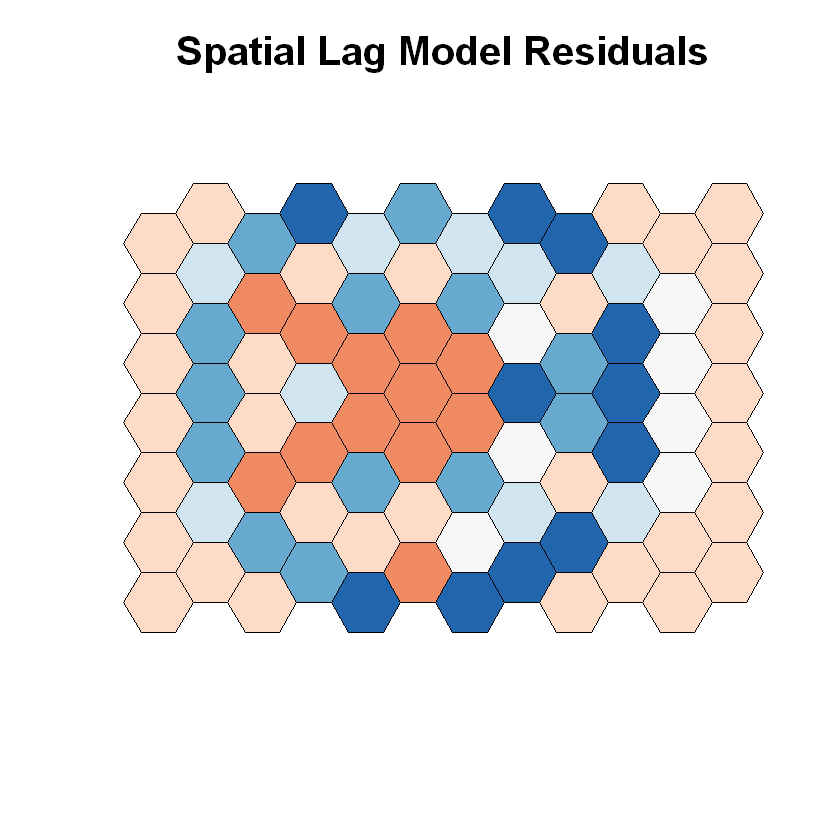

In [16]:
# make a choropleth map of the lag model residuals to visualize data
shp$lag.res <- resid(lag)
lagres <- as.numeric(shp$lag.res)
lagres.shade <- auto.shading(lagres,n=7,cols = rev(brewer.pal(7,"RdBu")))
choropleth(shp,lagres,shading=lagres.shade)
choro.legend(-57000,56500, lagres.shade,fmt="%6.2f")
title("Spatial Lag Model Residuals",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

In [17]:
# to what degree are the Lag model residuals spatially autocorrelated?
moran.test(shp$lag.res,W)


	Moran I test under randomisation

data:  shp$lag.res  
weights: W    

Moran I statistic standard deviate = 3.7245, p-value = 9.786e-05
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.159863873      -0.012048193       0.002130511 


In [18]:
# Spatial Error Model
sem <- errorsarlm(CRIME~MINPOP,data = shp, W)
summary(sem)

Warning message:
"Function errorsarlm moved to the spatialreg package"



Call:spatialreg::errorsarlm(formula = formula, data = data, listw = listw, 
    na.action = na.action, Durbin = Durbin, etype = etype, method = method, 
    quiet = quiet, zero.policy = zero.policy, interval = interval, 
    tol.solve = tol.solve, trs = trs, control = control)

Residuals:
     Min       1Q   Median       3Q      Max 
-8.43882 -3.11603 -0.13416  0.40638 51.53821 

Type: error 
Coefficients: (asymptotic standard errors) 
             Estimate Std. Error z value Pr(>|z|)
(Intercept)  4.809100  20.085125  0.2394   0.8108
MINPOP      -0.033273   0.107972 -0.3082   0.7580

Lambda: 0.96447, LR test value: 112.84, p-value: < 2.22e-16
Asymptotic standard error: 0.019911
    z-value: 48.438, p-value: < 2.22e-16
Wald statistic: 2346.2, p-value: < 2.22e-16

Log likelihood: -292.5695 for error model
ML residual variance (sigma squared): 42.774, (sigma: 6.5402)
Number of observations: 84 
Number of parameters estimated: 4 
AIC: 593.14, (AIC for lm: 703.98)


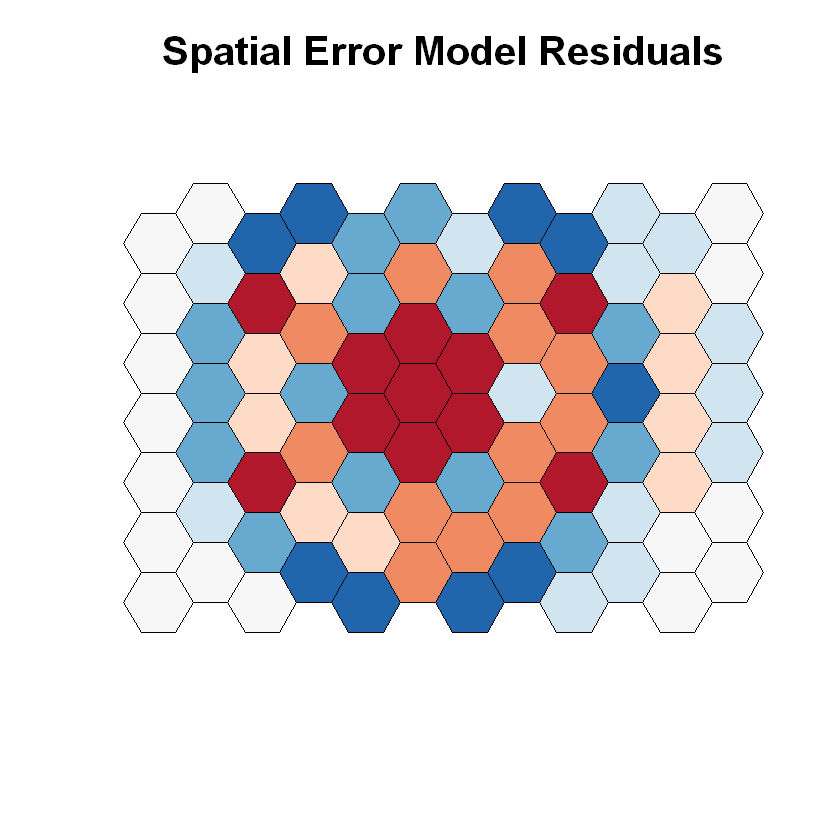

In [19]:
# make a choropleth map of the lag model residuals to visualize data
shp$sem.res <- resid(sem)
semres <- as.numeric(shp$sem.res)
semres.shade <- auto.shading(semres,n=7,cols = rev(brewer.pal(7,"RdBu")))
choropleth(shp,semres,shading=semres.shade)
choro.legend(-57000,56500, semres.shade,fmt="%6.2f")
title("Spatial Error Model Residuals",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

In [20]:
# to what degree are the Lag model residuals spatially autocorrelated?
moran.test(shp$sem.res,W)


	Moran I test under randomisation

data:  shp$sem.res  
weights: W    

Moran I statistic standard deviate = 4.5119, p-value = 3.213e-06
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.194320080      -0.012048193       0.002092058 


In [2]:
# converts an unprojected shapefile into Albers equal area projection using NAD83 datum 
# with appropriate parallels and longitude of origin to minimize distortion

to_aea <- function(shp) {
    ct<-readOGR(shp)
    lat.range <- as.numeric(st_bbox(ct)$ymax) - as.numeric(st_bbox(ct)$ymin)
    lat1 <- as.numeric(st_bbox(ct)$ymin) + lat.range / 6
    lat2 <- as.numeric(st_bbox(ct)$ymax) - lat.range / 6
    lat0 <- (lat1 + lat2) / 2
    long.origin <- (as.numeric(st_bbox(ct)$xmin) + as.numeric(st_bbox(ct)$xmax)) / 2
    proj=sprintf("+proj=aea +lat_1=%f +lat_2=%f +lat_0=%f +lon_0=%f +x_0=0 +y_0=0 +datum=NAD83", lat1, lat2, lat0, long.origin)
    ct.aea<-spTransform(ct, proj)
    return(ct.aea)
}

In [3]:
# convert the data to Albers Equal Area
ct.aea <- to_aea("censustract.shp")

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\orms0027\Documents\day_of_data\censustract.shp", layer: "censustract"
with 732 features
It has 7 fields
Integer64 fields read as strings:  Sum_TOTPOP Sum_MINORI 


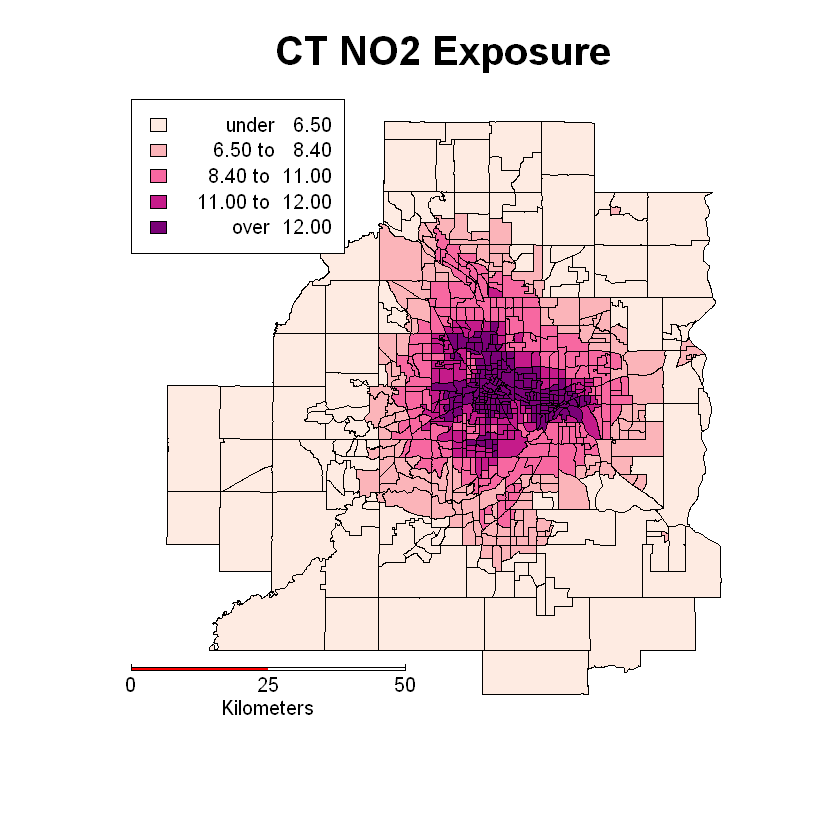

In [22]:
# make a choropleth map of NO2 exposure to visualize data
ctNO2 <- as.numeric(ct.aea$Avg_Avg_NO)
ctNO2.shade <- auto.shading(ctNO2,n=5,cols = brewer.pal(5,"RdPu"))
choropleth(ct.aea,ctNO2,shading=ctNO2.shade)
choro.legend(-57000,56500, ctNO2.shade,fmt="%6.2f")
title("CT NO2 Exposure",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

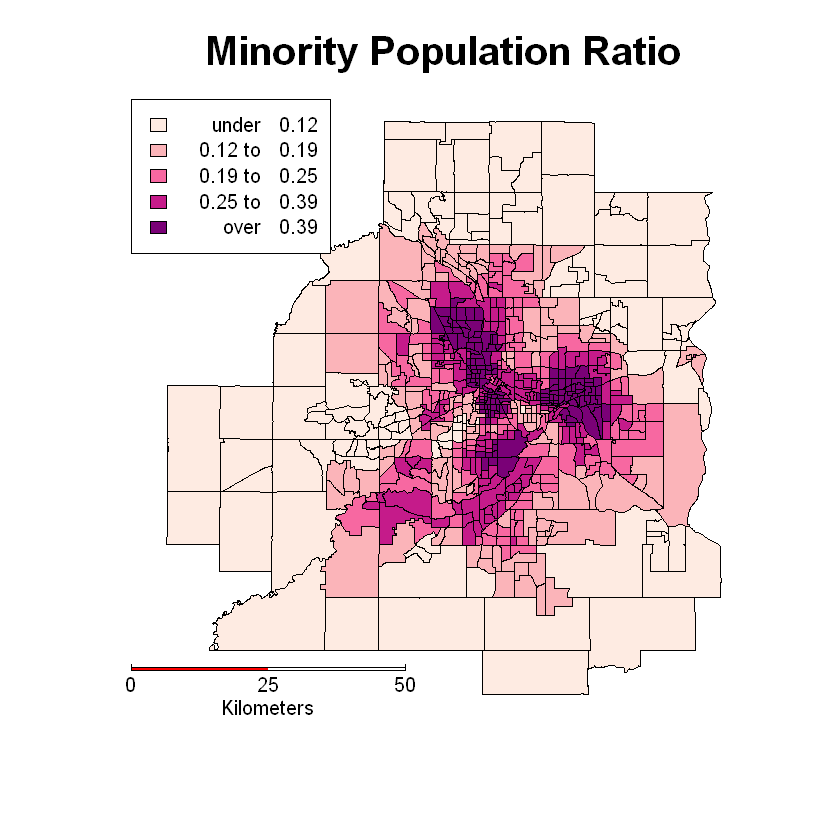

In [23]:
# make a choropleth map of minority population ratio to visualize data
minpop <- as.numeric(ct.aea$Pminori)
minpop.shade <- auto.shading(minpop,n=5,cols = brewer.pal(5,"RdPu"))
choropleth(ct.aea,minpop,shading=minpop.shade)
choro.legend(-57000,56500, minpop.shade,fmt="%6.2f")
title("Minority Population Ratio",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

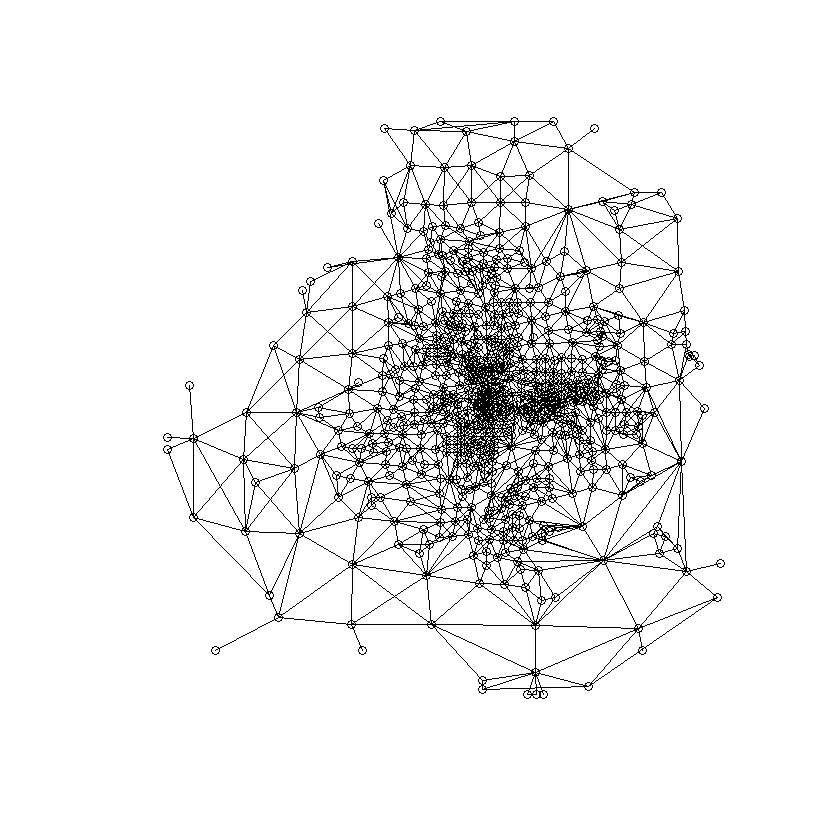

In [24]:
# convert spatial data to a contiguity graph to make it easy to tell which regions are neighbors
ct.nb<-poly2nb(ct.aea)

# visualize the contiguity graph
plot(ct.nb, coordinates(ct.aea))

In [25]:
# Calculating spatial autocorrelation requires constructing a row-standardized neighborhood weights matrix W
# for each row in W, all non-neighbors have a value of 0, while each neighbor has a value such that the row sum is 1
# (i.e. if a region has 2 neighbors, they will each have a value of 0.5)
ct.lw<- nb2listw(ct.nb)
ct.lw

Characteristics of weights list object:
Neighbour list object:
Number of regions: 732 
Number of nonzero links: 4548 
Percentage nonzero weights: 0.8487862 
Average number of links: 6.213115 

Weights style: W 
Weights constants summary:
    n     nn  S0       S1       S2
W 732 535824 732 254.8607 3036.543

In [26]:
# construct a linear regression model predicting NO2 values from minority population ratio
ct.ols <- lm(Avg_Avg_NO~Pminori, data = ct.aea)
summary(ct.ols)


Call:
lm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8050 -1.7311 -0.4376  1.5798  6.7407 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.4456     0.1486   43.38   <2e-16 ***
Pminori      11.2907     0.4531   24.92   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.298 on 730 degrees of freedom
Multiple R-squared:  0.4596,	Adjusted R-squared:  0.4589 
F-statistic: 620.8 on 1 and 730 DF,  p-value: < 2.2e-16


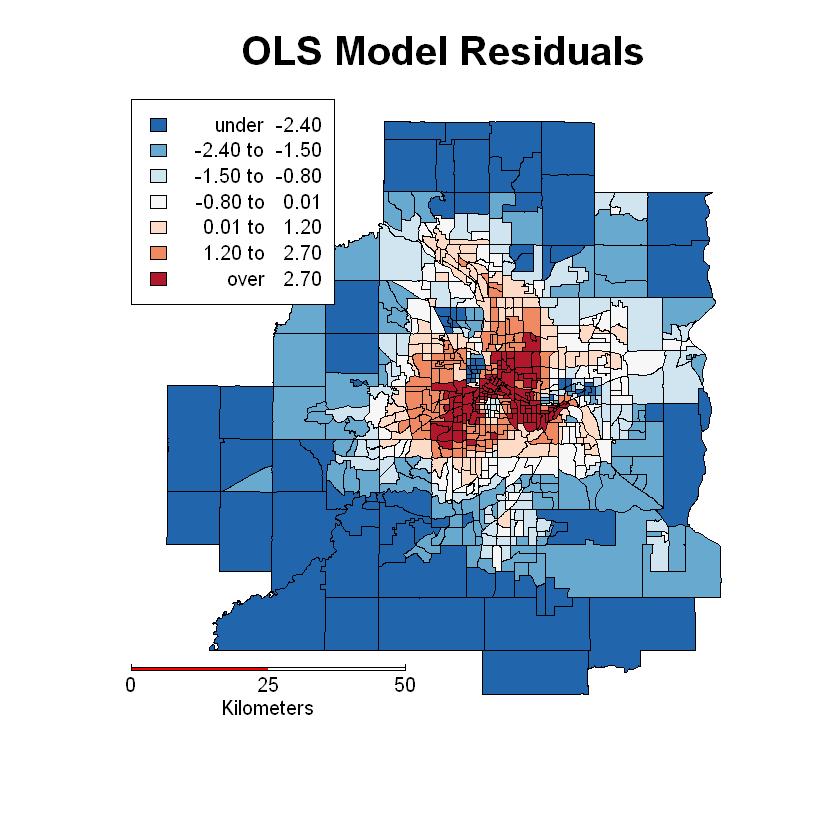

In [27]:
# make a choropleth map of the OLS model residuals to visualize data
ct.aea$ct.ols.res <- resid(ct.ols)
olsres <- as.numeric(ct.aea$ct.ols.res)
olsres.shade <- auto.shading(olsres,n=7,cols = rev(brewer.pal(7,"RdBu")))
choropleth(ct.aea,olsres,shading=olsres.shade)
choro.legend(-57000,56500, olsres.shade,fmt="%6.2f")
title("OLS Model Residuals",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

In [28]:
# to what degree are the OLS model residuals spatially autocorrelated?
moran.test(ct.aea$ct.ols.res,ct.lw)


	Moran I test under randomisation

data:  ct.aea$ct.ols.res  
weights: ct.lw    

Moran I statistic standard deviate = 39.982, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.867126471      -0.001367989       0.000471863 


In [29]:
# Use Lagrange multiplier test to determine if spatial lag or spatial error
# provides the better model fit
LM <- lm.LMtests(ct.ols, ct.lw, test="all")
LM


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea)
weights: ct.lw

LMerr = 1580.8, df = 1, p-value < 2.2e-16


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea)
weights: ct.lw

LMlag = 1687.9, df = 1, p-value < 2.2e-16


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea)
weights: ct.lw

RLMerr = 8.012, df = 1, p-value = 0.004647


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea)
weights: ct.lw

RLMlag = 115.09, df = 1, p-value < 2.2e-16


	Lagrange multiplier diagnostics for spatial dependence

data:  
model: lm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea)
weights: ct.lw

SARMA = 1695.9, df = 2, p-value < 2.2e-16


In [30]:
# create the spatial lag model
sar.ct <- lagsarlm(Avg_Avg_NO ~ Pminori, data = ct.aea, ct.lw)
summary(sar.ct)

Warning message:
"Function lagsarlm moved to the spatialreg package"



Call:spatialreg::lagsarlm(formula = formula, data = data, listw = listw, 
    na.action = na.action, Durbin = Durbin, type = type, method = method, 
    quiet = quiet, zero.policy = zero.policy, interval = interval, 
    tol.solve = tol.solve, trs = trs, control = control)

Residuals:
      Min        1Q    Median        3Q       Max 
-1.793903 -0.250355  0.014838  0.274793  1.752686 

Type: lag 
Coefficients: (asymptotic standard errors) 
             Estimate Std. Error z value  Pr(>|z|)
(Intercept) -0.031478   0.041590 -0.7569    0.4491
Pminori      0.591216   0.102019  5.7952 6.825e-09

Rho: 0.9851, LR test value: 2211.7, p-value: < 2.22e-16
Asymptotic standard error: 0.0052171
    z-value: 188.82, p-value: < 2.22e-16
Wald statistic: 35654, p-value: < 2.22e-16

Log likelihood: -540.8903 for lag model
ML residual variance (sigma squared): 0.18868, (sigma: 0.43437)
Number of observations: 732 
Number of parameters estimated: 4 
AIC: 1089.8, (AIC for lm: 3299.5)
LM test for residual 

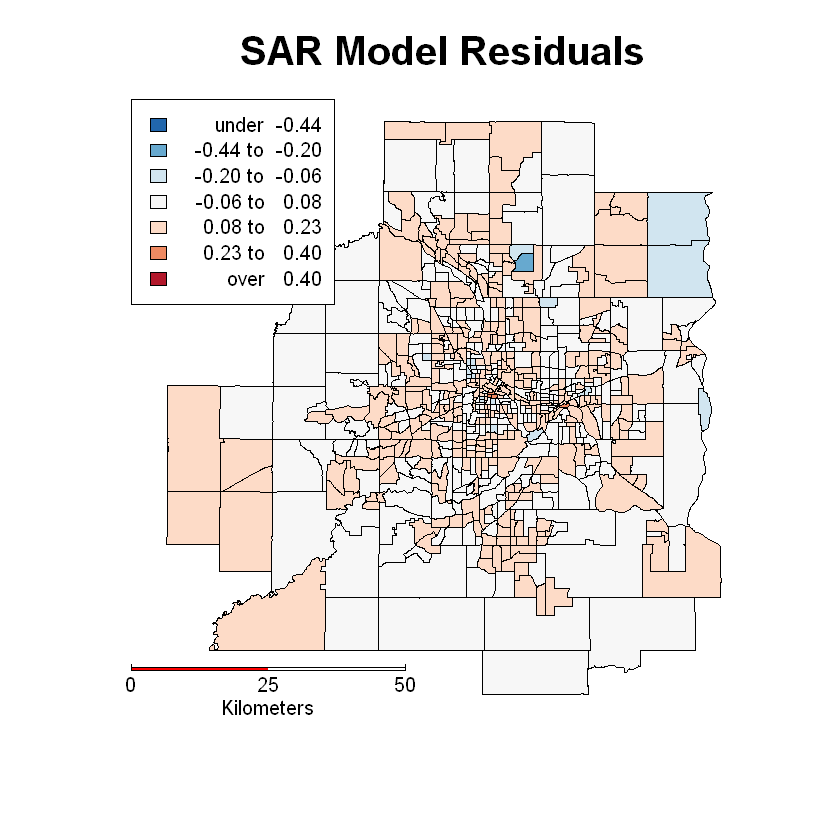

In [31]:
# make a choropleth map of the SAR model residuals to visualize data
ct.aea$ct.sar.res <- resid(sar.ct)
sarres <- as.numeric(ct.aea$ct.sar.res)
sarres.shade <- auto.shading(sarres,n=7,cols = rev(brewer.pal(7,"RdBu")))
choropleth(ct.aea,sarres,shading=olsres.shade)
choro.legend(-57000,56500, sarres.shade,fmt="%6.2f")
title("SAR Model Residuals",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

In [32]:
# to what degree are the SAR model residuals spatially autocorrelated?

moran.test(ct.aea$ct.sar.res,ct.lw)


	Moran I test under randomisation

data:  ct.aea$ct.sar.res  
weights: ct.lw    

Moran I statistic standard deviate = 6.0724, p-value = 6.3e-10
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.1303905902     -0.0013679891      0.0004707993 


In [35]:
# Spatial Error Model
sem.ct <- spatialreg::errorsarlm(Avg_Avg_NO ~ Pminori, data = ct.aea, ct.lw)
summary(sem.ct)


Call:spatialreg::errorsarlm(formula = Avg_Avg_NO ~ Pminori, data = ct.aea, 
    listw = ct.lw)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.8216236 -0.2279397  0.0059161  0.2615933  1.9456041 

Type: error 
Coefficients: (asymptotic standard errors) 
            Estimate Std. Error z value  Pr(>|z|)
(Intercept)  5.35305    4.31719  1.2399     0.215
Pminori      2.35984    0.32261  7.3148 2.578e-13

Lambda: 0.99637, LR test value: 2228.3, p-value: < 2.22e-16
Asymptotic standard error: 0.0022018
    z-value: 452.52, p-value: < 2.22e-16
Wald statistic: 204770, p-value: < 2.22e-16

Log likelihood: -532.5931 for error model
ML residual variance (sigma squared): 0.18019, (sigma: 0.42449)
Number of observations: 732 
Number of parameters estimated: 4 
AIC: 1073.2, (AIC for lm: 3299.5)


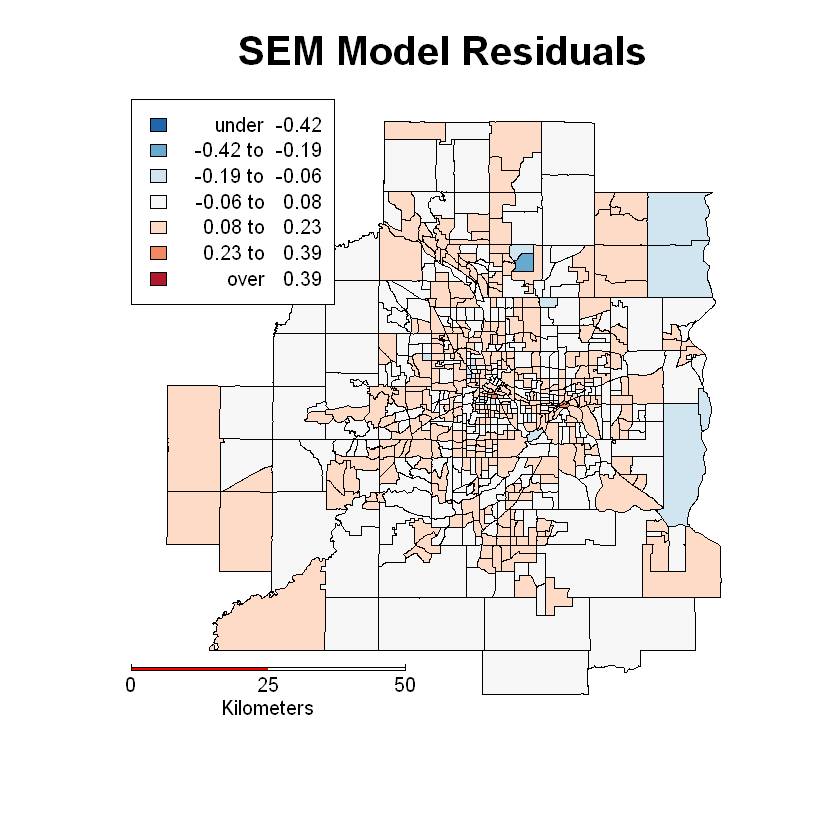

In [36]:
# make a choropleth map of the SAR model residuals to visualize data
ct.aea$ct.sem.res<-resid(sem.ct)
semres <- as.numeric(ct.aea$ct.sem.res)
semres.shade <- auto.shading(semres,n=7,cols = rev(brewer.pal(7,"RdBu")))
choropleth(ct.aea,semres,shading=olsres.shade)
choro.legend(-57000,56500, semres.shade,fmt="%6.2f")
title("SEM Model Residuals",cex.main=2)
map.scale(-32000,-48000,50000,"Kilometers",2,25,sfcol='red')

In [37]:
# to what degree are the SEM model residuals spatially autocorrelated?
moran.test(ct.aea$ct.sem.res,ct.lw)


	Moran I test under randomisation

data:  ct.aea$ct.sem.res  
weights: ct.lw    

Moran I statistic standard deviate = 6.2886, p-value = 1.601e-10
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.1350465353     -0.0013679891      0.0004705518 
